In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from v1dd_public import ARTIFACT_DIR
import seaborn as sns
from pathlib import Path
import sys, os
sys.path.insert(0, '/home/naomi/Desktop/code/v1dd-public/analysis-runner')
import run_decoding
from allen_v1dd.client import OPhysClient
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [2]:
# Set up the client and load the session
mouse_id = 'M427836'
col_vol_str = '23'
plane = 1
plane_name = f"Plane_{plane}"

DATA_DIR = Path("/home/naomi/Desktop/data/V1dd_nwbs/")
assert DATA_DIR.exists()
DATA_DIR.resolve()
client =  OPhysClient(DATA_DIR)
session = client.load_ophys_session(f"{mouse_id}_{col_vol_str}")
dff_traces = session.get_traces(plane=plane, trace_type='dff')

Stimulus: drifting_gratings_full, Color: #0173b2
Stimulus: drifting_gratings_windowed, Color: #de8f05
Stimulus: locally_sparse_noise, Color: #029e73
Stimulus: natural_images, Color: #d55e00
Stimulus: natural_images_12, Color: #cc78bc
Stimulus: natural_movie, Color: #ca9161
Stimulus: spontaneous, Color: #949494


/home/naomi/anaconda3/envs/v1dd-public-2/lib/python3.10/site-packages/matplotlib/transforms.py:2035: RuntimeWarning: invalid value encountered in double_scalars
  self._mtx[0, 2] += tx


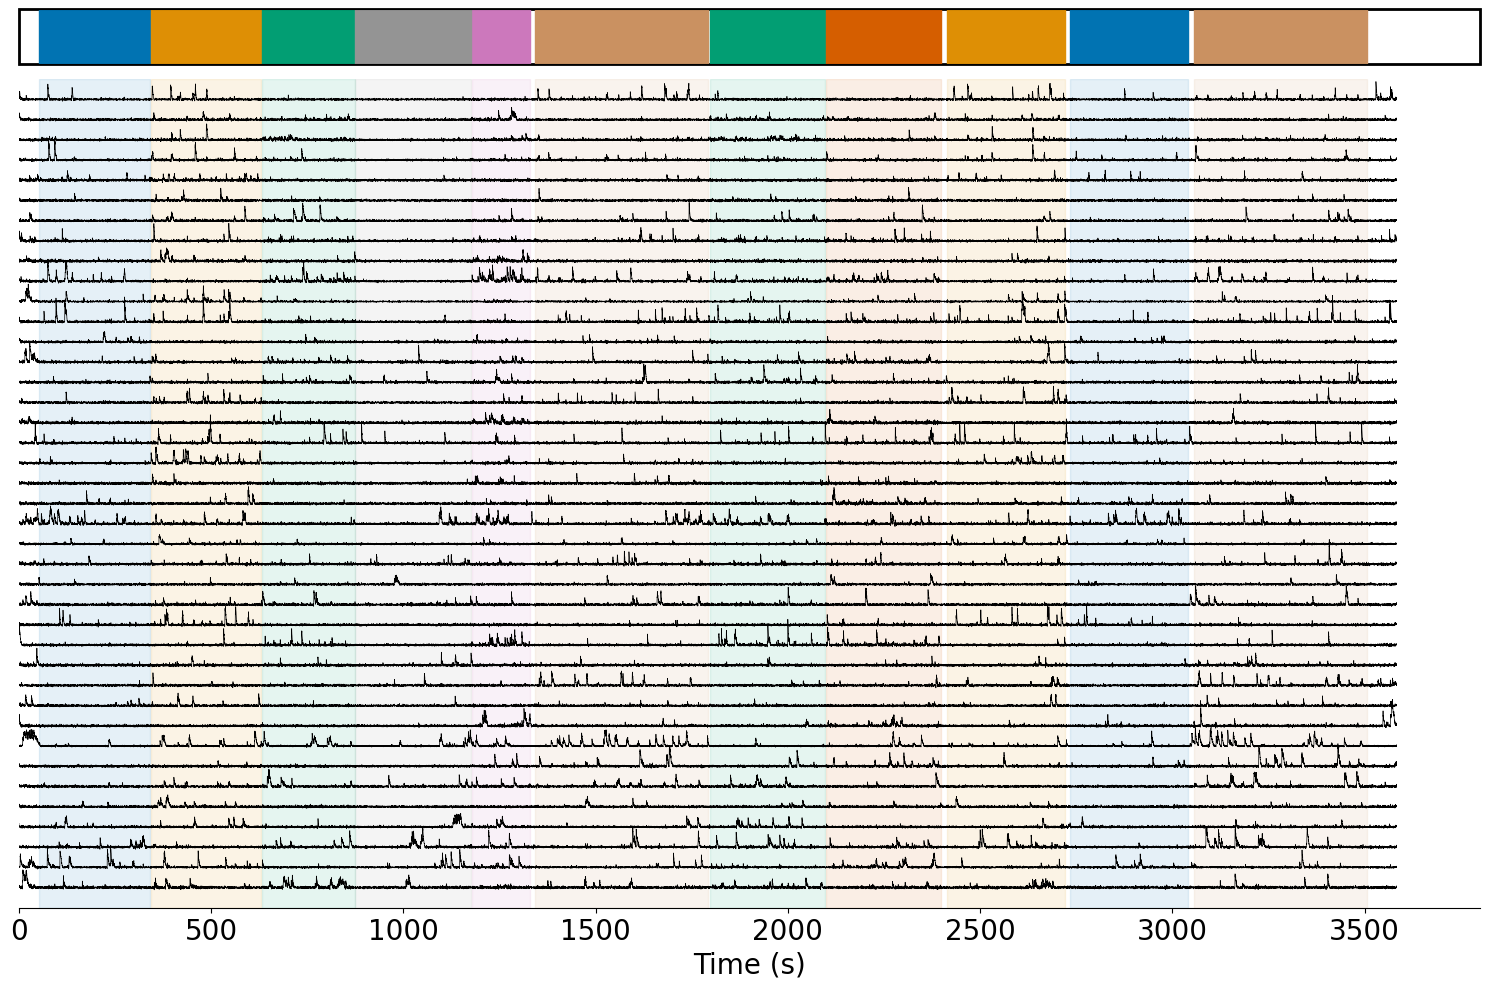

In [3]:
stims = [
    'drifting_gratings_full',
    'drifting_gratings_windowed',
    'locally_sparse_noise',
    'natural_images',
    'natural_images_12',
    'natural_movie',
    'spontaneous'
]
colors = sns.color_palette("colorblind", len(stims) + 1).as_hex()
stims_colors = {stim: color for stim, color in zip(stims, colors)}
stims_colors['spontaneous'] = colors[-1]  # Use the last color for spontaneous (grey)

fig, axs = plt.subplots(2, 1, figsize=(15, 10), gridspec_kw={'height_ratios': [1, 15]})

# Plotting the stimulus blocks
for stim, color in stims_colors.items():
    print(f'Stimulus: {stim}, Color: {color}')
    stim_table = session.get_stimulus_table(stim_name=stim)[0]

    starts = stim_table.start.values
    ends = stim_table.end.values

    start_end_pairs = []
    min_start = starts.min()
    max_end = ends.min()
    for i, (start, end) in enumerate(zip(starts, ends)):
        # Check if the current end is more than 10 s after the previous start (end of the stimulus block)
        try: 
            if end > 10 + starts[i-1]:
                start_end_pairs.append((min_start, max_end))
                min_start = np.inf
                max_end = -np.inf
        except IndexError:
            pass

        # Check if at the end of the list to add the last pair
        try:
            ends[i+1]
        except IndexError:
            start_end_pairs.append((min_start, max_end))


        if start < min_start:
            min_start = start
        if end > max_end:
            max_end = end
            
    for start, end in start_end_pairs:
        axs[0].axvspan(start, end, color=color, alpha=1, label=stim)
        axs[1].axvspan(start, end, color=color, alpha=0.1, label=stim)

axs[0].set_yticks([])
axs[0].set_ylim(0, 0.1)
axs[0].set_xlim(left=0, right=3800)
axs[0].set_xticks([])
axs[0].patch.set_linewidth(2)
axs[0].patch.set_edgecolor('black')


# Plotting the dff traces
offset = 3.5  # vertical space between traces
time = dff_traces.time.values 
for i, trace in enumerate(dff_traces.values[:40]):  # limit to first 40 traces for clarity
    axs[1].plot(time, trace + i * offset, color='black', linewidth=0.5)

axs[1].set_xlabel('Time (s)', fontsize=20)
axs[1].set_ylim(-offset, 40 * offset)
axs[1].set_xlim(left=0, right=3800)
axs[1].tick_params(axis='x', labelsize=20)
axs[1].yaxis.set_visible(False)
axs[1].spines[['top', 'right', 'left']].set_visible(False)

plt.tight_layout()


In [4]:
metrics_df = pd.read_csv('/home/naomi/Desktop/data/all_metrics_240426.csv')
rois = run_decoding.select_rois(session, plane, metrics_df=metrics_df, unduplicated=False)
dff_traces = dff_traces[rois]

In [5]:
stim_table, _ = session.get_stimulus_table("natural_movie")
stim_table

,start,end,frame
0,1342.000122,1342.016846,0
1,1342.033447,1342.050171,1
2,1342.066895,1342.083618,2
3,1342.100220,1342.116821,3
4,1342.133545,1342.150269,4
...,...,...,...
26995,3505.634277,3505.651123,895
26996,3505.667725,3505.684326,896
26997,3505.700928,3505.717773,897
26998,3505.734375,3505.750977,898


In [22]:
start_for_second_block = 13500
starts = stim_table.start.values[start_for_second_block:]
ends = stim_table.end.values[start_for_second_block:]
frames = stim_table.frame.values[start_for_second_block:]
y_data = frames

In [44]:
x_data = np.zeros((len(frames), len(rois)))
for i, (start, end) in enumerate(zip(starts, ends)):
    array = (dff_traces.time.values - start) > 0
    start_idx = np.where(array)[0][0]
    # array = (dff_traces.time.values - end) > 0
    # end_idx = np.where(array)[0][0]
    # if end_idx > start_idx:  # Ensure there is a valid range
    #     x_data[i, :] = dff_traces.values[:, start_idx:end_idx].mean(axis=0)
    # else:
    x_data[i, :] = dff_traces.values[:, start_idx]  # Use the value at start_idx if no range

x_data.shape, y_data.shape

((13500, 484), (13500,))

In [51]:
np.unique(y_data)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [52]:
def mapping(frame):
    if frame in np.arange(0, 50):
        return 0
    elif frame in np.arange(50, 100):
        return 1
    elif frame in np.arange(100, 150):
        return 2
    elif frame in np.arange(150, 200):
        return 3
    elif frame in np.arange(200, 250):  
        return 4
    elif frame in np.arange(250, 300):
        return 5
    elif frame in np.arange(300, 350):
        return 6
    elif frame in np.arange(350, 400):
        return 7
    elif frame in np.arange(400, 450):
        return 8
    elif frame in np.arange(450, 500):
        return 9
    elif frame in np.arange(500, 550):
        return 10
    elif frame in np.arange(550, 600):
        return 11
    elif frame in np.arange(600, 650):
        return 12
    elif frame in np.arange(650, 700):
        return 13
    elif frame in np.arange(700, 750):
        return 14
    elif frame in np.arange(750, 800):
        return 15
    elif frame in np.arange(800, 850):
        return 16
    elif frame in np.arange(850, 900):
        return 17
    else:
        print('error, frame out of range')

In [53]:
y_data_mapped = np.array([mapping(frame) for frame in y_data])
np.unique(y_data_mapped)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17])

In [54]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data_mapped, test_size=0.2, random_state=42)

# Perform k-nearest neighbors decoding
# param_grid = {'n_neighbors': list(range(1, 30))}
# knn = KNeighborsClassifier(metric='correlation')
# grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
# grid_search.fit(x_train, y_train)
# best_k = grid_search.best_params_['n_neighbors']
# print(f"Best k: {best_k}")

# Fit the best model
knn = KNeighborsClassifier(n_neighbors=10, metric='correlation')
knn.fit(x_train, y_train)

# Predict on training and test data
y_pred_train = knn.predict(x_train)
y_pred_test = knn.predict(x_test)

# Calculate accuracy
print(f"Training accuracy: {metrics.accuracy_score(y_train, y_pred_train)}")
print(f"Test accuracy: {metrics.accuracy_score(y_test, y_pred_test)}")

Training accuracy: 0.85
Test accuracy: 0.7992592592592592


In [ ]:
dff_traces

(484,)

In [41]:
array = (dff_traces.time.values - ends[0]) > 0
end_idx = np.where(array)[0][0]
end_idx
# dff_traces.values[:, start_idx]

18330

In [42]:
array = (dff_traces.time.values - starts[0]) > 0
start_idx = np.where(array)[0][0]
start_idx
# dff_traces.values[:, start_idx]

18329

In [38]:
dff_traces.values.shape

(484, 21490)